### Autoregressive and Latent Models

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

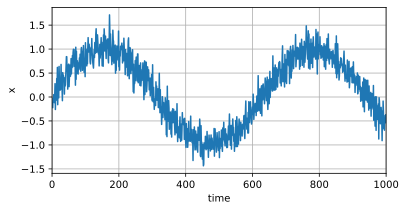

In [78]:
class Data(d2l.DataModule) : 
    def __init__(self, batch_size = 16, T = 1000, num_train = 600, tau = 4) : 
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2
        
    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)] # (tau, T-tau)
        self.features = torch.stack(features).T # (T-tau, tau) 
        self.labels = self.x[self.tau:].reshape((-1, 1)) # (tau : T, 1)
        """
        
        features = [
        [x₁, x₂, ..., x₇],
        [x₂, x₃, ..., x₈],
        [x₃, x₄, ..., x₉]
        ]
        
        # After stacking and transposing, for labels we take (tau, 1)
        [x₁, x₂, x₃] -> x4
        [x₂, x₃, x₄] -> x5
        ...
        [x₇, x₈, x₉]

        """
        
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)
        
    
data = Data(tau = 3)
d2l.plot(data.time, data.x, 'time', 'x', xlim=[0, 1000], figsize=(6, 3))

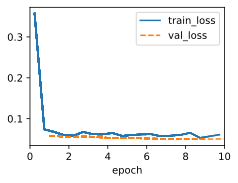

In [77]:
# past tau = 4 observations for next value
model = d2l.LinearRegression(lr=0.05)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
preds = model(data.features).detach().numpy() # (T-tau, 1)

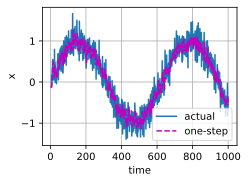

In [63]:
d2l.plot(data.time[data.tau:], [data.labels, preds], 'time', 'x', legend=["actual", "one-step"]) # preds (tau, T)

It is one step ahead prediction, which means that we use the past tau observations to predict the next value.
k step ahead prediction means that we use the past tau observations to predict the next k values -> so we need to use the predicted values as input.
$(x_1 x_2, x_3) -> x_4$
$(x_2, x_3, x_{4_pred}) -> x_5$
$(x_3, x_{4_pred}, x_{5_pred}) -> x_6$

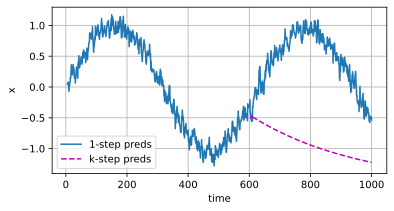

In [ ]:
# K-step prediction
k_steps_preds = torch.zeros(data.T)
k_steps_preds[:] = data.x # fill it with original

for i in range(data.num_train + data.tau, data.T): # (604, 1000)
    k_steps_preds[i] = model(k_steps_preds[i - data.tau:i].reshape((1, -1))) # update the value itself.
    
k_steps_preds = k_steps_preds.detach().numpy() # (1000,) (604, 1000) -> Important

d2l.plot([data.time[data.tau:], data.time[data.num_train + data.tau:]],
            [preds, k_steps_preds[data.num_train + data.tau:]], 'time', 'x',
            legend=['1-step preds', 'k-step preds'], figsize=(6, 3))

#! Question is post a time there are just using the predictions right ? So how is it k_th step prediction?


Diverges very well here. We are seeing the errors build up here and thus causing it to deviate a lot. For instance the weather predictions are good for 24 hours but they start to decay post that because of errors. For $k_{th}$ step ahead prediction. 

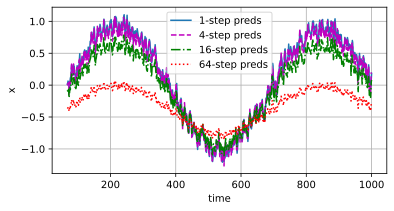

In [ ]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

#! They have made this computationally efficient. 
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))


One key insight is that while plotting it just shows only the last step prediction. 
So for the 63 steps, it generates the predictions but only shows the 64th output.
Kind of its not recursive then uses lets say 4 (actual ) to generate next 64 then uses only the 64 for predictions and then moves to next 4 to generate the 65. As the code is made very computationally efficient i am having troubles understanding it. 

Main difference to quality of the model i think should be lag, it should converge after a point but again using many past observations -> but again that depends on the type of process you have right, if it depends on the past 3-4 then lag of 4 should be fine or else not. 

We should always respect the temporal order of the data and never train on the future data $\to$ Primary reason is building up of the errors. 

### Working with Raw Texts

### Text to Sequence Data

In [79]:
import collections
import random
import re
import torch
from d2l import torch as d2l

In [173]:
class Vocab : 
    def __init__(self, tokens = [], min_freq = 0, reserved_tokens = []) : 
        if tokens and isinstance(tokens[0], list) : 
            tokens = [token for line in tokens for token in line]
            
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key = lambda x : x[1], reverse=True)
        
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq]))) # mapping list[id] = token
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)} # best use case for enumerate
        
    def __len__(self) : 
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens) : # tokens to indices
        if not isinstance(tokens, (list, tuple)): # if the instance is not avaliable
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices) : # indices to tokens
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    
    def unk(self) : 
        return self.token_to_idx['<unk>']


class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
        super(TimeMachine, self).__init__()  # Fixed: Remove d2l.TimeMachine, use TimeMachine
        self.save_hyperparameters()
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]
        
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
    
    def _preprocess(self, text): 
        return re.sub('[^A-Za-z]+', ' ', text).lower() # a regex to only have A-Z nothing else
    
    def _tokenize(self, text): 
        return list(text)

    def build(self, raw_text, vocab=None): 
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: 
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab
    
    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)
    
    
data = TimeMachine(batch_size=2, num_steps=10)
raw_text = data._download()
text = data._preprocess(raw_text)
corpus, vocab = data.build(raw_text)
print(f"corpus : {len(corpus)} & vocab : {len(vocab)}")


corpus : 173428 & vocab : 28


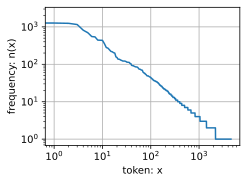

In [154]:
# words as the tokens
words = text.split()
vocab = Vocab(words)

freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

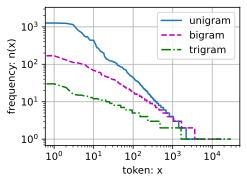

In [158]:
# Bigrams and more
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
trigram_tokens = ['--'.join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]
bigram_vocab = Vocab(bigram_tokens)
trigram_vocab = Vocab(trigram_tokens)

bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])